#  Image Analysis

## Imports

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.misc import bytescale, toimage
import sys
import os
#import gzip
#from PIL import Image as pilImage

from image import Image, show
#from utils import unpickle, reshape_cifar10_image, process_cifar10_image
from utils.utils import unpickle, reshape_cifar10_image, process_cifar10_image
from utils.utils import block_resampling, jackknife_err, get_plot_num
from utils.count_bonds import CountBonds
from utils.block_images import block_image
from utils.plot_helper import errorbar_plot

markers = ['s', 'H', 'd', 'v', 'p', 'P']
colors = ['#2A9Df8', '#FF920B', '#65e41d', '#be67ff', '#ff7e79', '#959595']
markeredgecolors = ['#0256a3', '#ed4c18',  '#00B000', '#6633cc',
                    '#ee2324','#1c2022']

%matplotlib inline

In [278]:
cm.plasma(0)

(0.050382999999999997, 0.029803, 0.52797499999999997, 1.0)

## Download CIFAR-10 dataset and extract into './cifar10_data/' directory

In [2]:
# download cifar-10-data and extract into './cifar10_data/' directory
! mkdir cifar10_data 
! curl -O https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
! tar -xvf cifar-10-python.tar.gz -C ./cifar10_data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  3900k      0  0:00:42  0:00:42 --:--:-- 2420kM    0     0  3955k      0  0:00:42  0:00:18  0:00:24 3382kM    0     0  4195k      0  0:00:39  0:00:26  0:00:13 5285k  0     0  4143k      0  0:00:40  0:00:28  0:00:12 4105k3M    0     0  4135k      0  0:00:40  0:00:30  0:00:10 3556k
x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1


## Testing with CIFAR-10

### Define relevant directories, load first batch of data 

In [2]:
cifar10_data_prefix = './data/cifar10_data/cifar-10-batches-py/'
cifar10_data_batch1_file = cifar10_data_prefix + 'data_batch_1'
cifar10_data_batch2_file = cifar10_data_prefix + 'data_batch_2'
cifar10_data_batch3_file = cifar10_data_prefix + 'data_batch_3'
cifar10_data_batch4_file = cifar10_data_prefix + 'data_batch_4'
cifar10_data_batch5_file = cifar10_data_prefix + 'data_batch_5'

cifar10_batch1 = unpickle(cifar10_data_batch1_file)

In [3]:
cifar10_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

### Examples

(<matplotlib.figure.Figure at 0x12775dcc0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12776aa20>)

(<matplotlib.figure.Figure at 0x12775df28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11e344940>)

(<matplotlib.figure.Figure at 0x11e33e470>,
 <matplotlib.axes._subplots.AxesSubplot at 0x127a8d668>)

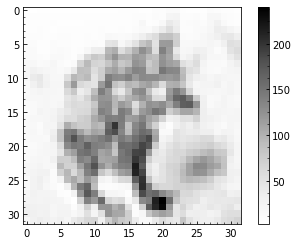

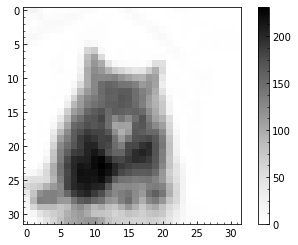

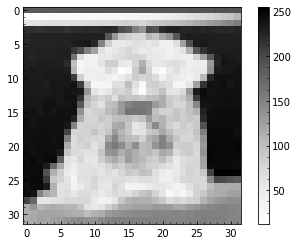

In [216]:
# extract first three images from dataset and plot, just for reference
image0 = process_cifar10_image(cifar10_batch1[b'data'][0])
image1 = process_cifar10_image(cifar10_batch1[b'data'][1])
image2 = process_cifar10_image(cifar10_batch1[b'data'][2])

show(image0)
show(image1)
show(image2)

In [ ]:
# extract B/W boundaries using cutoff = 0.5 and show resulting image
img0 = Image(image0)
boundary_img0 = img0.get_boundaries(0.5)
show(boundary_img0)

#### Iteratively block sample image (example)

In [21]:
# iteratively block image:
#    (64, 64) --> (32, 32) --> (16,16) --> (8, 8) --> (4, 4)
blocked1_boundary_img0 = block_image(boundary_img0)
blocked2_boundary_img0 = block_image(blocked1_boundary_img0)
blocked3_boundary_img0 = block_image(blocked2_boundary_img0)
blocked4_boundary_img0 = block_image(blocked3_boundary_img0)

(<matplotlib.figure.Figure at 0x11109bcf8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1167ddb38>)

(<matplotlib.figure.Figure at 0x11109b9e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1169414e0>)

(<matplotlib.figure.Figure at 0x1167b8710>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11136b6d8>)

(<matplotlib.figure.Figure at 0x1168d08d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1166f70b8>)

(<matplotlib.figure.Figure at 0x116700d30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1166b5be0>)

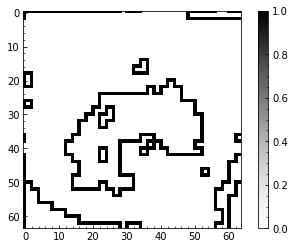

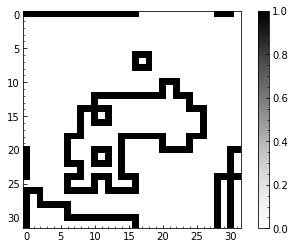

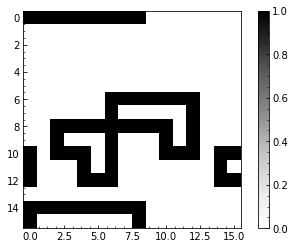

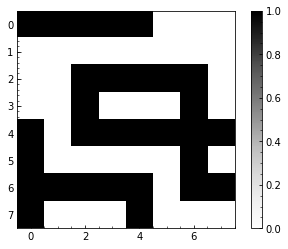

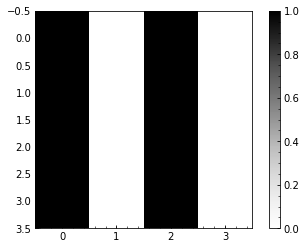

In [22]:
show(boundary_img0)
show(blocked1_boundary_img0.reshape((32,32)))
show(blocked2_boundary_img0.reshape((16,16)))
show(blocked3_boundary_img0.reshape((8,8)))
show(blocked4_boundary_img0.reshape((4,4)))

### Shuffle data and load images for analysis

In [242]:
# shuffle data
np.random.shuffle(cifar10_batch1[b'data'])
# select first num_sample_images from batch1 as sample data
num_sample_images = 500
cifar10_images0 = np.array([process_cifar10_image(img) for img in
                            cifar10_batch1[b'data'][:num_sample_images]])
#cifar10_images1 = np.array([process_cifar10_image(img) for img in
#                            cifar10_batch1[b'data'][num_sample_images:2*num_sample_images]])
#cifar10_images2 = np.array([process_cifar10_image(img) for img in
#                            cifar10_batch1[b'data'][2*num_sample_images:3*num_sample_images]])
print(cifar10_images0.shape)
#print(cifar10_images1.shape)
#print(cifar10_images2.shape)

(500, 32, 32)


### Define cutoffs and obtain boundary images

In [ ]:
img0 = Image(cifar10_boundary_images0)

In [265]:
# create array of cutoffs for converting image to black/white pixels
#cutoffs = np.arange(0.1, 1., 0.05)
#cutoffs = [0.2, 0.3, 0.4]
cutoffs = list(np.arange(0.2, 0.4, 0.05))
cutoffs.extend(list(np.arange(0.4, 0.7, 0.01)))
cutoffs.extend(list(np.arange(0.7, 0.9, 0.05)))
#cutoffs.extend(list(np.array([0.8, 0.9, 1.0])))

cifar10_boundary_images0 = []
#cifar10_boundary_images1 = []
#cifar10_boundary_images2 = []
#zip_cifar_images = zip(cifar10_images0, cifar10_images1, cifar10_images2)
#for (image0, image1, image2) in zip_cifar_images:
for image in cifar10_images0:
    img0 = Image(image)
    #img1 = Image(image1)
    #img2 = Image(image2)
    # for each image, try different cutoff values and append resulting image
    # to boundary_images array
    boundary_images0 = np.array([img0.get_boundaries(cutoff) 
                                for cutoff in cutoffs])
    #boundary_images1 = np.array([img1.get_boundaries(cutoff) 
    #                            for cutoff in cutoffs])
    #boundary_images2 = np.array([img2.get_boundaries(cutoff) 
    #                            for cutoff in cutoffs])
    # create array with the boundary_images obtained from each cutoff value
    # to cifar10_boundary_images array, with one image per row
    # i.e. cifar10_boundary_images will have shape:
    #    [num_images, num_cutoffs, 32, 32] 
    cifar10_boundary_images0.append(np.array(boundary_images0))
    #cifar10_boundary_images1.append(np.array(boundary_images1))
    #cifar10_boundary_images2.append(np.array(boundary_images2))
cifar10_boundary_images0 = np.array(cifar10_boundary_images0)
#cifar10_boundary_images1 = np.array(cifar10_boundary_images1)
#cifar10_boundary_images2 = np.array(cifar10_boundary_images2)
print(cifar10_boundary_images0.shape)
#print(cifar10_boundary_images1.shape)
#print(cifar10_boundary_images2.shape)

(500, 39, 64, 64)


### Block boundary images $L = 64 \rightarrow 32$

In [266]:
blocked_boundary_images0 = []
#blocked_boundary_images1 = []
#blocked_boundary_images2 = []
#zip_bdy_images = zip(cifar10_boundary_images0, cifar10_boundary_images1,
#                     cifar10_boundary_images2)
#for (images0, images1, images2) in zip_bdy_images:
for images in cifar10_boundary_images0:
    boundary_images0 = []
    #boundary_images1 = []
    #boundary_images2 = []
    original_size = images[0].shape[0]
    new_size = original_size // 2
    #zip_images = zip(images0, images1, images2)
    #for (cutoff_image0, cutoff_image1, cutoff_image2) in zip_images:
    for cutoff_image in images:
        boundary_images0.append(block_image(cutoff_image).reshape(new_size,
                                                                  new_size))
        #boundary_images1.append(block_image(cutoff_image1).reshape(new_size,
        #                                                           new_size))
        #boundary_images2.append(block_image(cutoff_image2).reshape(new_size,
        #                                                           new_size))
    blocked_boundary_images0.append(np.array(boundary_images0))
    #blocked_boundary_images1.append(np.array(boundary_images1))
    #blocked_boundary_images2.append(np.array(boundary_images2))
blocked_boundary_images0 = np.array(blocked_boundary_images0)
#blocked_boundary_images1 = np.array(blocked_boundary_images1)
#blocked_boundary_images2 = np.array(blocked_boundary_images2)
print(blocked_boundary_images0.shape)
#print(blocked_boundary_images1.shape)
#print(blocked_boundary_images2.shape)

(500, 39, 32, 32)


### Block again! (using blocked images from above) $ L = 32 \rightarrow 16$

In [267]:
blocked1_boundary_images0 = []
#blocked1_boundary_images1 = []
#blocked1_boundary_images2 = []
#zip_bdy_images1 = zip(blocked_boundary_images0, blocked_boundary_images1,
#                     blocked_boundary_images2)
#for (images0, images1, images2) in zip_bdy_images1:
for images in blocked_boundary_images0:
    boundary_images0 = []
    #boundary_images1 = []
    #boundary_images2 = []
    original_size = images[0].shape[0]
    new_size = original_size // 2
    #zip_images = zip(images0, images1, images2)
    #for (cutoff_image0, cutoff_image1, cutoff_image2) in zip_images:
    for cutoff_image in images:
        boundary_images0.append(block_image(cutoff_image).reshape(new_size,
                                                                  new_size))
        #boundary_images1.append(block_image(cutoff_image1).reshape(new_size,
        #                                                           new_size))
        #boundary_images2.append(block_image(cutoff_image2).reshape(new_size,
        #                                                           new_size))
    blocked1_boundary_images0.append(np.array(boundary_images0))
    #blocked1_boundary_images1.append(np.array(boundary_images1))
    #blocked1_boundary_images2.append(np.array(boundary_images2))
blocked1_boundary_images0 = np.array(blocked1_boundary_images0)
#blocked1_boundary_images1 = np.array(blocked1_boundary_images1)
#blocked1_boundary_images2 = np.array(blocked1_boundary_images2)
print(blocked1_boundary_images0.shape)
#print(blocked1_boundary_images1.shape)
#print(blocked1_boundary_images2.shape)

(500, 39, 16, 16)


### And again! (using blocked images from above) $ L = 16 \rightarrow 8$

In [268]:
blocked2_boundary_images0 = []
#blocked2_boundary_images1 = []
#blocked2_boundary_images2 = []
#zip_bdy_images1 = zip(blocked_boundary_images0, blocked_boundary_images1,
#                     blocked_boundary_images2)
#for (images0, images1, images2) in zip_bdy_images1:
for images in blocked1_boundary_images0:
    boundary_images0 = []
    #boundary_images1 = []
    #boundary_images2 = []
    original_size = images[0].shape[0]
    new_size = original_size // 2
    #zip_images = zip(images0, images1, images2)
    #for (cutoff_image0, cutoff_image1, cutoff_image2) in zip_images:
    for cutoff_image in images:
        boundary_images0.append(block_image(cutoff_image).reshape(new_size,
                                                                  new_size))
        #boundary_images1.append(block_image(cutoff_image1).reshape(new_size,
        #                                                           new_size))
        #boundary_images2.append(block_image(cutoff_image2).reshape(new_size,
        #                                                           new_size))
    blocked2_boundary_images0.append(np.array(boundary_images0))
    #blocked2_boundary_images1.append(np.array(boundary_images1))
    #blocked2_boundary_images2.append(np.array(boundary_images2))
blocked2_boundary_images0 = np.array(blocked2_boundary_images0)
#blocked2_boundary_images1 = np.array(blocked2_boundary_images1)
#blocked2_boundary_images2 = np.array(blocked2_boundary_images2)
print(blocked2_boundary_images0.shape)
#print(blocked2_boundary_images1.shape)
#print(blocked2_boundary_images2.shape)

(500, 39, 8, 8)


### Run bond counter ($\langle N_b\rangle$, $\langle \Delta_{N_b}^2\rangle$) on unblocked images: $L = 64$  

In [269]:
# swap first two axes so that each row corresponds 
# to a unique value of greyscale cutoff, across all images
cifar10_boundary_imagesT0 = np.transpose(cifar10_boundary_images0, 
                                         (1, 0, 2, 3))
#cifar10_boundary_imagesT1 = np.transpose(cifar10_boundary_images1, 
#                                         (1, 0, 2, 3))
#cifar10_boundary_imagesT2 = np.transpose(cifar10_boundary_images2, 
                                         #(1, 0, 2, 3))

bond_stats0 = []
for cutoff_images in cifar10_boundary_imagesT0:
    count_bonds0 = CountBonds(image_set=cutoff_images, num_blocks=20)
    bond_stats0.append(count_bonds0.count_bonds())

#bond_stats1 = []
#for cutoff_images in cifar10_boundary_imagesT1:
#    count_bonds1 = CountBonds(image_set=cutoff_images, num_blocks=10)
#    bond_stats1.append(count_bonds1.count_bonds())

#bond_stats2 = []
#for cutoff_images in cifar10_boundary_imagesT2:
#    count_bonds2 = CountBonds(image_set=cutoff_images, num_blocks=20)
#    bond_stats2.append(count_bonds2.count_bonds())
    
bond_stats0 = np.array(bond_stats0)
#bond_stats1 = np.array(bond_stats1)
#bond_stats2 = np.array(bond_stats2)

### Run bond counter ($\langle N_b\rangle$, $\langle \Delta_{N_b}^2\rangle$) on blocked images: $L = 32$  

In [270]:
# swap first two axes so that each row corresponds 
# to a unique value of greyscale cutoff, across all images
blocked_boundary_imagesT0 = np.transpose(blocked_boundary_images0, 
                                         (1, 0, 2, 3))
#blocked_boundary_imagesT1 = np.transpose(blocked_boundary_images1, 
#                                         (1, 0, 2, 3))
#blocked_boundary_imagesT2 = np.transpose(blocked_boundary_images2, 
#                                         (1, 0, 2, 3))

bond_stats0_blocked = []
for cutoff_images in blocked_boundary_imagesT0:
    count_bonds0_blocked = CountBonds(image_set=cutoff_images, num_blocks=20)
    bond_stats0_blocked.append(count_bonds0_blocked.count_bonds())
    
#bond_stats1_blocked = []
#for cutoff_images in blocked_boundary_imagesT1:
#    count_bonds1_blocked = CountBonds(image_set=cutoff_images, num_blocks=10)
#    bond_stats1_blocked.append(count_bonds1_blocked.count_bonds())
    
#bond_stats2_blocked = []
#for cutoff_images in blocked_boundary_imagesT2:
#    count_bonds2_blocked = CountBonds(image_set=cutoff_images, num_blocks=10)
#    bond_stats2_blocked.append(count_bonds2_blocked.count_bonds())
    
bond_stats0_blocked = np.array(bond_stats0_blocked)
#bond_stats1_blocked = np.array(bond_stats1_blocked)
#bond_stats2_blocked = np.array(bond_stats2_blocked)

### Run bond counter ($\langle N_b\rangle$, $\langle \Delta_{N_b}^2\rangle$) on twice blocked images: $L = 16$  

In [271]:
# swap first two axes so that each row corresponds 
# to a unique value of greyscale cutoff, across all images
blocked1_boundary_imagesT0 = np.transpose(blocked1_boundary_images0, 
                                          (1, 0, 2, 3))
#blocked1_boundary_imagesT1 = np.transpose(blocked1_boundary_images1, 
#                                          (1, 0, 2, 3))
#blocked1_boundary_imagesT2 = np.transpose(blocked1_boundary_images2, 
#                                         (1, 0, 2, 3))

bond_stats0_blocked1 = []
for cutoff_images in blocked1_boundary_imagesT0:
    count_bonds0_blocked1 = CountBonds(image_set=cutoff_images, num_blocks=20)
    bond_stats0_blocked1.append(count_bonds0_blocked1.count_bonds())
    
#bond_stats1_blocked1 = []
#for cutoff_images in blocked1_boundary_imagesT1:
#    count_bonds1_blocked1 = CountBonds(image_set=cutoff_images, num_blocks=10)
#    bond_stats1_blocked1.append(count_bonds1_blocked1.count_bonds())
    
#bond_stats2_blocked1 = []
#for cutoff_images in blocked_boundary_imagesT2:
#    count_bonds2_blocked1 = CountBonds(image_set=cutoff_images, num_blocks=10)
#    bond_stats2_blocked1.append(count_bonds2_blocked1.count_bonds())
    
bond_stats0_blocked1 = np.array(bond_stats0_blocked1)
#bond_stats1_blocked1 = np.array(bond_stats1_blocked1)
#bond_stats2_blocked1 = np.array(bond_stats2_blocked1)

### Run bond counter ($\langle N_b\rangle$, $\langle \Delta_{N_b}^2\rangle$) on thrice blocked images: $L = 8$  

In [272]:
# swap first two axes so that each row corresponds 
# to a unique value of greyscale cutoff, across all images
blocked2_boundary_imagesT0 = np.transpose(blocked2_boundary_images0, 
                                          (1, 0, 2, 3))
#blocked2_boundary_imagesT1 = np.transpose(blocked2_boundary_images1, 
#                                          (1, 0, 2, 3))
#blocked2_boundary_imagesT2 = np.transpose(blocked2_boundary_images2, 
#                                         (1, 0, 2, 3))

bond_stats0_blocked2 = []
for cutoff_images in blocked2_boundary_imagesT0:
    count_bonds0_blocked2 = CountBonds(image_set=cutoff_images, num_blocks=20)
    bond_stats0_blocked2.append(count_bonds0_blocked2.count_bonds())
    
#bond_stats1_blocked2 = []
#for cutoff_images in blocked2_boundary_imagesT1:
#    count_bonds1_blocked2 = CountBonds(image_set=cutoff_images, num_blocks=10)
#    bond_stats1_blocked2.append(count_bonds1_blocked2.count_bonds())
    
#bond_stats2_blocked2 = []
#for cutoff_images in blocked_boundary_imagesT2:
#    count_bonds2_blocked2 = CountBonds(image_set=cutoff_images, num_blocks=10)
#    bond_stats2_blocked2.append(count_bonds2_blocked2.count_bonds())
    
bond_stats0_blocked2 = np.array(bond_stats0_blocked2)
#bond_stats1_blocked2 = np.array(bond_stats1_blocked2)
#bond_stats2_blocked2 = np.array(bond_stats2_blocked2)

## Plots

### $\langle N_b\rangle$ vs. cutoff

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle N_b\\rangle / V_{eff}$')

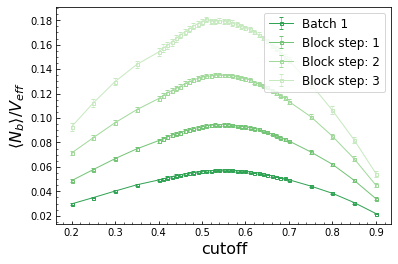

In [307]:
Nb_vals = np.array([bond_stats0[:, 0] / (64 * 64), 
                    bond_stats0_blocked[:, 0] / (32 * 32),
                    bond_stats0_blocked1[:, 0] / (16 * 16),
                    bond_stats0_blocked2[:, 0] / (8 * 8)])
                    #bond_stats1[:, 0] / (64 * 64),
                    #bond_stats1_blocked[:, 0] / (32 * 32),
                    #bond_stats1_blocked1[:, 0] / (16 * 16),
                    #bond_stats1_blocked2[:, 0] / (8 * 8),
                    #bond_stats2[:, 0] / (64 * 64),
                    #bond_stats2_blocked[:, 0] / (32 * 32),
                    #bond_stats2_blocked1[:, 0] / (16 * 16),
                    #bond_stats2_blocked2[:, 0] / (8 * 8)])
Nb_errs = np.array([bond_stats0[:, 1] / (64 * 64),
                    bond_stats0_blocked[:, 1] / (32 * 32),
                    bond_stats0_blocked1[:, 1] / (16 * 16),
                    bond_stats0_blocked2[:, 1] / (8 * 8)])
                    #bond_stats1[:, 1] / (64 * 64),
                    #bond_stats1_blocked[:, 1] / (32 * 32),
                    #bond_stats1_blocked1[:, 1] / (16 * 16),
                    #bond_stats1_blocked2[:, 1] / (8 * 8),
                    #bond_stats2[:, 1] / (64 * 64),
                    #bond_stats2_blocked[:, 1] / (32 * 32),
                    #bond_stats2_blocked1[:, 1] / (16 * 16),
                    #bond_stats2_blocked2[:, 1] / (8 * 8)])
Nb_xlabel = "cutoff"
Nb_ylabel = r"$\langle N_b\rangle / V_{eff}$"
Nb_values = {'x': np.array(cutoffs), 'y': Nb_vals[0], 'y_err': Nb_errs[0]}
Nb_labels = {'fig_labels': ['Batch 1', 
                            'Block step: 1', 'Block step: 2',  'Block step: 3'],
                            #'Batch 2', 
                            #'Block step: 1', 'Block step: 2', 'Block step: 3',
                            #'Batch 3', 
                            #'Block step: 1', 'Block step: 2', 'Block step: 3'],
             'x_label': Nb_xlabel, 'y_label': Nb_ylabel}
limits = {'x_lim': (min(cutoffs) - 0.02, max(cutoffs) + 0.02)}
Nb_avg_plot_dir = './plots/Nb_avg/'
Nb_avg_plot_num = get_plot_num(Nb_avg_plot_dir)
Nb_avg_plot_file = (Nb_avg_plot_dir 
                    + f'Nb_avg_vs_cutoff_{Nb_avg_plot_num}.png')
#Nb_fig, Nb_ax = errorbar_plot(Nb_values, Nb_labels, Nb_avg_plot_file, 
#                              limits, markersize=3.5)
cc = [0, 4, 8, 12]
#for idx, i in enumerate(range(3, len(Nb_vals), 4)):
#for idx, i in enumerate(range(len(Nb_vals))):
fig, ax = plt.subplots()
ax.errorbar(cutoffs, Nb_vals[0], yerr=Nb_errs[0],
            label=Nb_labels['fig_labels'][0], 
            marker=markers[0],
            #marker=markers[(i-3) // 4],
            markersize=3, fillstyle='none',
            #color=colors[(i-2) // 3], 
            color=cm.tab20c(0 + cc[2]),
            #color=cm.coolwarm_r(10),
            #markeredgecolor=cm.coolwarm_r(0),
            #markeredgecolor=markeredgecolors[(i-2) // 3],
            ls='-', lw=1., elinewidth=0.5, capsize=2., capthick=1.)
ax.errorbar(cutoffs, Nb_vals[1], yerr=Nb_errs[1],
            label=Nb_labels['fig_labels'][1], 
            #marker=markers[(i-2) // 3],
            marker=markers[0],
            markersize=3, fillstyle='none',
            color=cm.tab20c(1 + cc[2]),
            #color=colors[(i-2) // 3], 
            #color=cm.coolwarm_r(30),
            #markeredgecolor=cm.coolwarm_r(20),
            #markeredgecolor=markeredgecolors[(i-2) // 3],
            ls='-', lw=1., elinewidth=0.5, capsize=2., capthick=1.)
ax.errorbar(cutoffs, Nb_vals[2], yerr=Nb_errs[2],
            label=Nb_labels['fig_labels'][2], 
            #marker=markers[(i-2) // 3],
            marker=markers[0],
            markersize=3, fillstyle='none',
            color=cm.tab20c(2 + cc[2]),
            #color=colors[(i-2) // 3], 
            #color=cm.tab20c(1 + cc[2]),
            #color=cm.coolwarm_r(50),
            #markeredgecolor=cm.coolwarm_r(40),
            #markeredgecolor=markeredgecolors[(i-2) // 3],
            ls='-', lw=1., elinewidth=0.5, capsize=2., capthick=1.)
ax.errorbar(cutoffs, Nb_vals[3], yerr=Nb_errs[3],
            label=Nb_labels['fig_labels'][3], 
            #marker=markers[(i-2) // 3],
            marker=markers[0],
            markersize=3, fillstyle='none',
            color=cm.tab20c(3 + cc[2]),
            #color=colors[(i-2) // 3], 
            #color=cm.tab20c(2 + cc[2]),
            #color=cm.coolwarm_r(70),
            #markeredgecolor=cm.coolwarm_r(60),
            #markeredgecolor=markeredgecolors[(i-2) // 3],
            ls='-', lw=1., elinewidth=0.5, capsize=2., capthick=1.)
leg = ax.legend(loc='best', markerscale=1., fontsize=12)
ax.set_xlabel(Nb_labels['x_label'], fontsize=16)
ax.set_ylabel(Nb_labels['y_label'], fontsize=16)
Nb_avg_plot_num = get_plot_num(Nb_avg_plot_dir)
Nb_avg_plot_file = (Nb_avg_plot_dir 
                    + f'Nb_avg_vs_cutoff_{Nb_avg_plot_num}.png')
fig.savefig(Nb_avg_plot_file, dpi=400, bbox_inches='tight')
plt.show()

#fig.savefig(Nb_avg_plot_file, dpi=400, bbox_inches='tight')

### $\langle \Delta_{N_b}^2\rangle$ vs. cutoff

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle \\Delta_{N_b}^2\\rangle/ V_{eff}$')

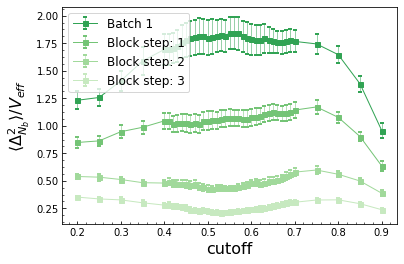

In [309]:
bond_stats0 = np.array(bond_stats0)
bond_stats0_blocked = np.array(bond_stats0_blocked)

markers = ['s', 'H', 'd', 'v', 'p', 'P']
colors = ['#2A9Df8', '#FF920B', '#65e41d', '#be67ff', '#ff7e79', '#959595']
markeredgecolors = ['#0256a3', '#ed4c18',  '#00B000', '#6633cc',
                    '#ee2324','#1c2022']
delta_Nb_vals = np.array([bond_stats0[:, 2] / (64 * 64), 
                          bond_stats0_blocked[:, 2] / (32 * 32),
                          bond_stats0_blocked1[:, 2] / (16 * 16),
                          bond_stats0_blocked2[:, 2] / (8 * 8)])
                          #bond_stats1[:, 2] / (64 * 64), 
                          #bond_stats1_blocked[:, 2] / (32 * 32),
                          #bond_stats1_blocked1[:, 2] / (16 * 16),
                          #bond_stats1_blocked2[:, 2] / (8 * 8),
                          #bond_stats2[:, 2] / (64 * 64), 
                          #bond_stats2_blocked[:, 2] / (32 * 32),
                          #bond_stats2_blocked1[:, 2] / (16 * 16),
                          #bond_stats2_blocked2[:, 2] / (8 * 8)])
delta_Nb_errs = np.array([bond_stats0[:, 3] / (64 * 64),
                          bond_stats0_blocked[:, 3] / (32 * 32),
                          bond_stats0_blocked1[:, 3] / (16 * 16),
                          bond_stats0_blocked2[:, 3] / (8 * 8)])
                          #bond_stats1[:, 3] / (64 * 64),
                          #bond_stats1_blocked[:, 3] / (32 * 32),
                          #bond_stats1_blocked1[:, 3] / (16 * 16),
                          #bond_stats1_blocked2[:, 3] / (8 * 8),
                          #bond_stats2[:, 3] / (64 * 64),
                          #bond_stats2_blocked[:, 3] / (32 * 32),
                          #bond_stats2_blocked1[:, 3] / (16 * 16),
                          #bond_stats2_blocked2[:, 3] / (8 * 8)])
delta_Nb_xlabel = "cutoff"
delta_Nb_ylabel = r"$\langle \Delta_{N_b}^2\rangle/ V_{eff}$"
delta_Nb_values = {'x': np.array(cutoffs), 'y': Nb_vals[0], 'y_err': Nb_errs[0]}
delta_Nb_labels = {'fig_labels': ['Batch 1', 
                                  'Block step: 1', 'Block step: 2', 'Block step: 3'],
                                  #'Batch 2', 
                                  #'Block step: 1', 'Block step: 2', 'Block step 3',
                                  #'Batch 3', 
                                  #'Block step: 1', 'Block step: 2', 'Block step 3'],
                   'x_label': delta_Nb_xlabel, 'y_label': delta_Nb_ylabel}
limits = {'x_lim': (min(cutoffs) - 0.02, max(cutoffs) + 0.02)}
delta_Nb_plot_dir = './plots/delta_Nb/'
delta_Nb_plot_num = get_plot_num(delta_Nb_plot_dir)
delta_Nb_plot_file = (delta_Nb_plot_dir 
                    + f'delta_Nb_vs_cutoff_{delta_Nb_plot_num}.png')
#Nb_fig, Nb_ax = errorbar_plot(Nb_values, Nb_labels, Nb_avg_plot_file, 
#                              limits, markersize=3.5)

                          
cc = [0, 4, 8, 12]
#for (idx, i) in enumerate(range(3, len(delta_Nb_vals), 4)):
fig, ax = plt.subplots()
ax.errorbar(cutoffs, delta_Nb_vals[0], yerr=delta_Nb_errs[0],
            label=delta_Nb_labels['fig_labels'][0], 
            marker=markers[0],
            markersize=5, fillstyle='full',
            color=cm.tab20c(0 + cc[2]),
            #color=colors[i-1], 
            #markeredgecolor=markeredgecolors[i-1],
            ls='-', lw=1., elinewidth=0.5, capsize=2., capthick=2.)
ax.errorbar(cutoffs, delta_Nb_vals[1], yerr=delta_Nb_errs[1],
            label=delta_Nb_labels['fig_labels'][1], 
            marker=markers[0],
            markersize=5, fillstyle='full',
            color=cm.tab20c(1 + cc[2]),
            #color=colors[i-1], 
            #markeredgecolor=markeredgecolors[i-1],
            ls='-', lw=1., elinewidth=0.5, capsize=2., capthick=2.)
ax.errorbar(cutoffs, delta_Nb_vals[2], yerr=delta_Nb_errs[2],
            label=delta_Nb_labels['fig_labels'][2], 
            marker=markers[0],
            markersize=5, fillstyle='full',
            color=cm.tab20c(2 + cc[2]),
            #color=colors[i-1], markeredgecolor=markeredgecolors[i-1],
            ls='-', lw=1., elinewidth=0.5, capsize=2., capthick=2.)
ax.errorbar(cutoffs, delta_Nb_vals[3], yerr=delta_Nb_errs[3],
            label=Nb_labels['fig_labels'][3], 
            marker=markers[0],
            markersize=5, fillstyle='full',
            color=cm.tab20c(3 + cc[2]),
            #color=colors[i-1], markeredgecolor=markeredgecolors[i-1],
            ls='-', lw=1., elinewidth=1., capsize=2., capthick=2.)
leg = ax.legend(loc='best', markerscale=1, fontsize=12)
ax.set_xlabel(delta_Nb_labels['x_label'], fontsize=16)
ax.set_ylabel(delta_Nb_labels['y_label'], fontsize=16)
delta_Nb_plot_num = get_plot_num(delta_Nb_plot_dir)
delta_Nb_plot_file = (delta_Nb_plot_dir 
                    + f'delta_Nb_vs_cutoff_{delta_Nb_plot_num}.png')
fig.savefig(delta_Nb_plot_file, dpi=400, bbox_inches='tight')
#fig.savefig(Nb_avg_plot_file, dpi=400, bbox_inches='tight')